In [13]:
import matplotlib.pyplot as plt
import numpy as np
from src.segmentation import segmentation
from src.segmentation.models import PretrainedUNet, tuned_PretrainedUNet
import torch, torchvision
from pydicom import dcmread
from PIL import Image
torch.manual_seed(42)
torch.use_deterministic_algorithms(True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Torch device: ", device)

## Load pre-learnt
models = ["unet-6v.pt", "os_unet_v1.pt", "os_unet_v2_adam.pt",
 "os_unet_v3_adam_es20pct_rot25.pt", "t_unet_v4_adam_es20pct_rot25.pt"]
mnames = {0:"A", 1:"B", 2:"C", 3:"D", 4:"E"}
unets = []
for model_name in models:
    if model_name.startswith("t_"):
        unet = tuned_PretrainedUNet(
            in_channels=1,
            out_channels=2, 
            batch_norm=True, 
            #upscale_mode="bilinear"
        )
    else:
        unet = PretrainedUNet(
            in_channels=1,
            out_channels=2, 
            batch_norm=True, 
            upscale_mode="bilinear"
        )
    unet.load_state_dict(torch.load(f"models/lung_seg/{model_name}", map_location=torch.device("cpu")))
    unet.to(device)
    unets.append(unet)
    print(f"{model_name} succesfully loaded...") #omit load_state_dict output

#in_images, out_images = segmentation.process_dcim(batch, unet, device)

Torch device:  cpu
unet-6v.pt succesfully loaded...
os_unet_v1.pt succesfully loaded...
os_unet_v2_adam.pt succesfully loaded...
os_unet_v3_adam_es20pct_rot25.pt succesfully loaded...
t_unet_v4_adam_es20pct_rot25.pt succesfully loaded...


In [14]:
# fpath = "/Volumes/Samsung_T5/MA/manifest-1638522923319/segmented_sample/A000801/01-03-1901-NA-CHEST AP PORT-62879/1.000000-AP-12195/1-1.dcm"
# dcm = dcmread(fpath)
# origin = dcm.pixel_array
# origin = np.round(origin/origin.max()*255) #scale between [0,1]
# origin = Image.fromarray(origin).convert("P")

def infer_and_plot(fpath, model, plot=True, preproc=None):
    
    dcm = dcmread(fpath)
    origin = dcm.pixel_array

    if preproc is not None:
        origin = preproc(origin)
        origin = np.round(origin * 255)
        origin = Image.fromarray(origin).convert("P")
    else:
        origin = np.round(origin/origin.max() * 255) 
        origin = Image.fromarray(origin).convert("P")
    #print("input array: ", np.min(np.array(origin)), np.max(np.array(origin)))
    origin = torchvision.transforms.functional.resize(origin, (512, 512))
    origin = torchvision.transforms.functional.to_tensor(origin) - 0.5
    #print("tensor: ", torch.min(origin), torch.max(origin))

    with torch.no_grad():
                origin = torch.stack([origin])
                origin = origin.to(device)
                out = model(origin)
                softmax = torch.nn.functional.log_softmax(out, dim=1)
                out = torch.argmax(softmax, dim=1)
                
                origin = origin[0].to("cpu")  # back to [0,1]
                out = out[0].to("cpu")

    img = torchvision.transforms.functional.to_pil_image(origin + 0.5).convert("RGB")
    mask =  torchvision.transforms.functional.to_pil_image(torch.cat([
        torch.zeros_like(origin),
        torch.stack([out.float()]),
        torch.zeros_like(origin)
    ]))

    if plot:    
        fig, ax = plt.subplots(1, 3,
            figsize=(14,7)
        )
        ax[0].imshow(img)
        ax[1].imshow(Image.blend(img, mask, 0.2))
        ax[2].imshow(mask)
    else:
        return Image.blend(img, mask, 0.2)

In [15]:
sample = ['/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh2/A724565/12-31-1900-NA-CHEST AP PORT-07182/1.000000-AP-10035/1-1.dcm', '/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh2/A602816/12-28-1900-NA-CHEST AP PORT-66036/1.000000-AP-80374/1-1.dcm', '/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh2/A851848/01-02-1901-NA-CHEST AP PORT-70361/1.000000-AP-97588/1-1.dcm', '/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh2/A403529/01-21-1901-NA-CHEST AP PORT-99554/1.000000-AP-01788/1-1.dcm']


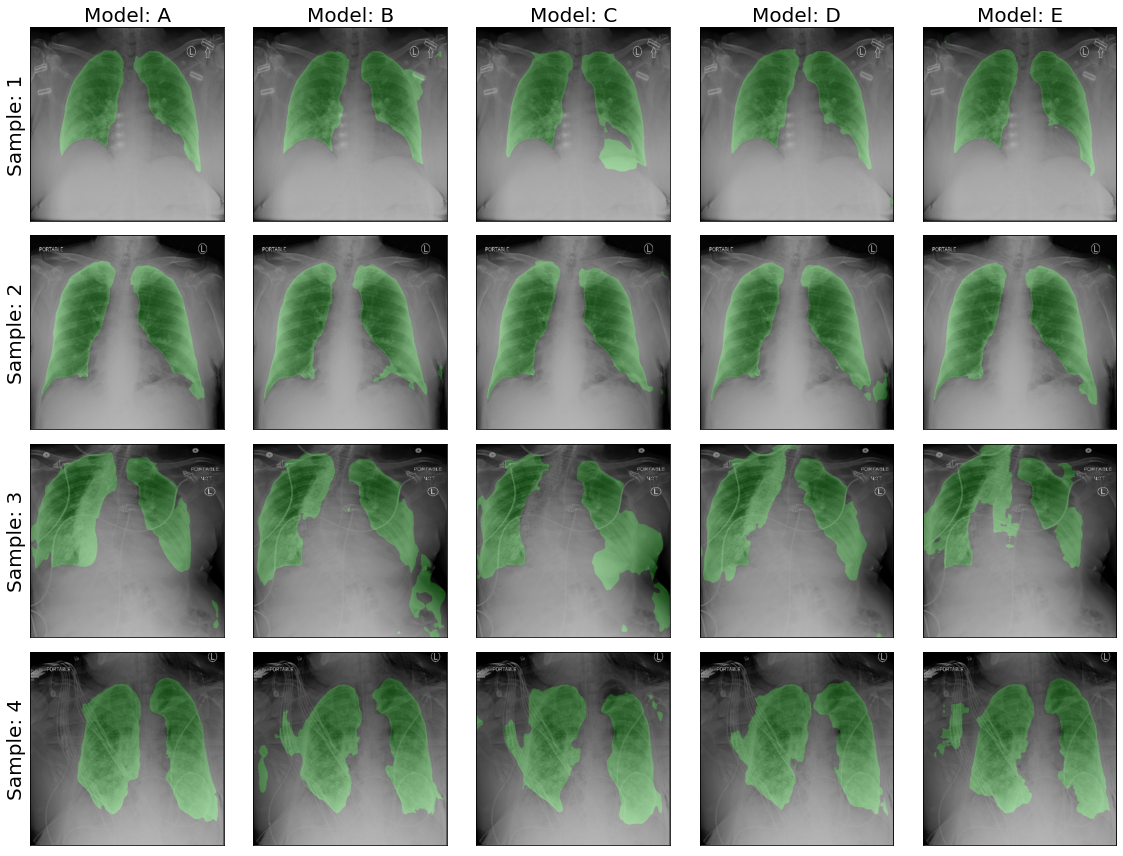

In [24]:
fig, ax = plt.subplots(len(sample), len(unets), figsize=(16,12), facecolor=(1., 1., 1.), sharex=True, sharey=True)
for j, m in enumerate(unets):
    for i, s in enumerate(sample):
        ax[i, j].imshow(infer_and_plot(s, m, plot=False, preproc=None))
        ax[i, j].set_xticks([]) 
        ax[i, j].set_yticks([])
        if j == 0: 
            ax[i,j].set_ylabel(f"Sample: {i+1}", fontsize=20)
        if i == 0:
            ax[i, j].set_title(f"Model: {mnames[j]}", fontsize=20)
fig.tight_layout()
fig.savefig("../thesis/figures/impl/model_comparison_nopp.png")

In [17]:
from skimage.filters import gaussian
from skimage.exposure import equalize_adapthist

def blur_adapthisteq(img):
    _img = img.copy()
    _img = gaussian(_img, sigma=1)
    _img = equalize_adapthist(_img, clip_limit=0.005)
    return _img

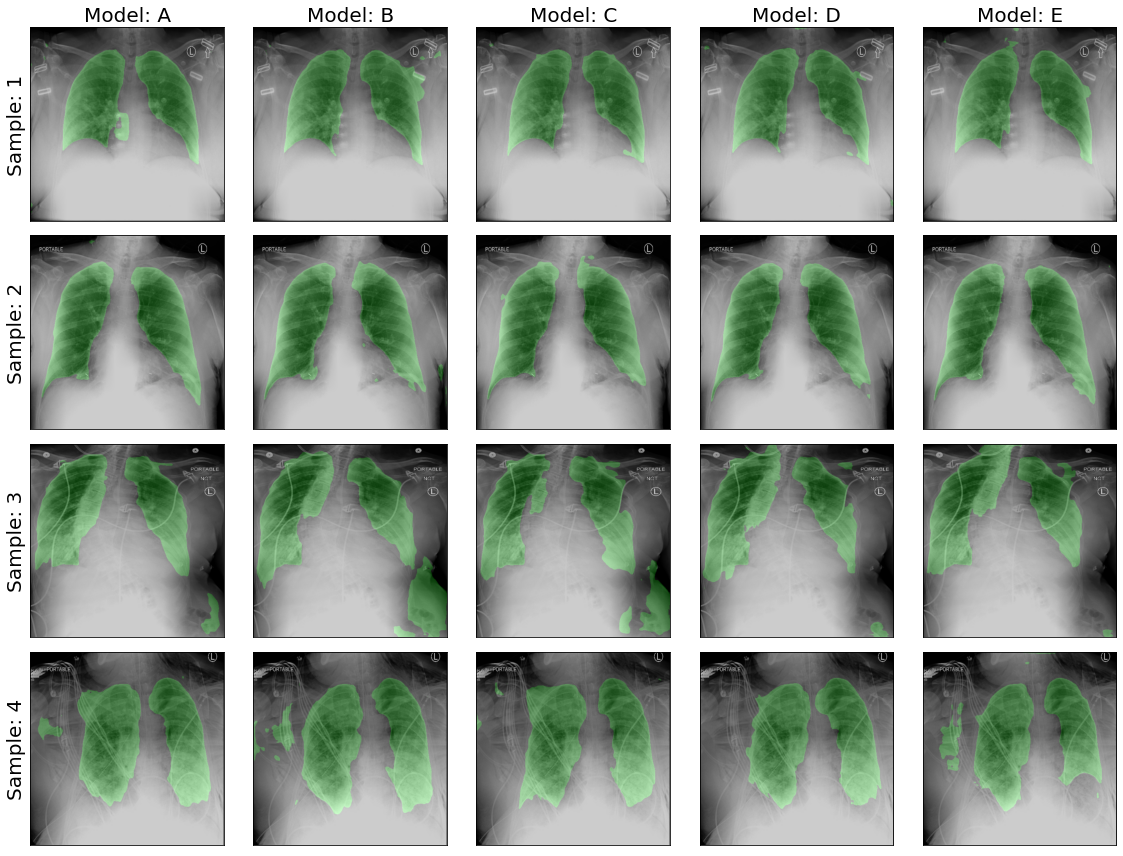

In [18]:
fig, ax = plt.subplots(len(sample), len(unets), figsize=(16,12), facecolor=(1., 1., 1.), sharex=True, sharey=True)
for j, m in enumerate(unets):
    for i, s in enumerate(sample):
        ax[i, j].imshow(infer_and_plot(s, m, plot=False, preproc=blur_adapthisteq))
        ax[i, j].set_xticks([]) 
        ax[i, j].set_yticks([])
        if j == 0: 
            ax[i,j].set_ylabel(f"Sample: {i+1}", fontsize=20)
        if i == 0:
            ax[i, j].set_title(f"Model: {mnames[j]}", fontsize=20)
fig.tight_layout()
fig.savefig("../thesis/figures/impl/model_comparison_blur_adapthist_clip005.png")

In [19]:
from skimage.filters import gaussian
from skimage.exposure import equalize_adapthist

def blur_adapthisteq(img):
    _img = img.copy()
    _img = gaussian(_img, sigma=1)
    _img = equalize_adapthist(_img, clip_limit=0.0075)
    return _img

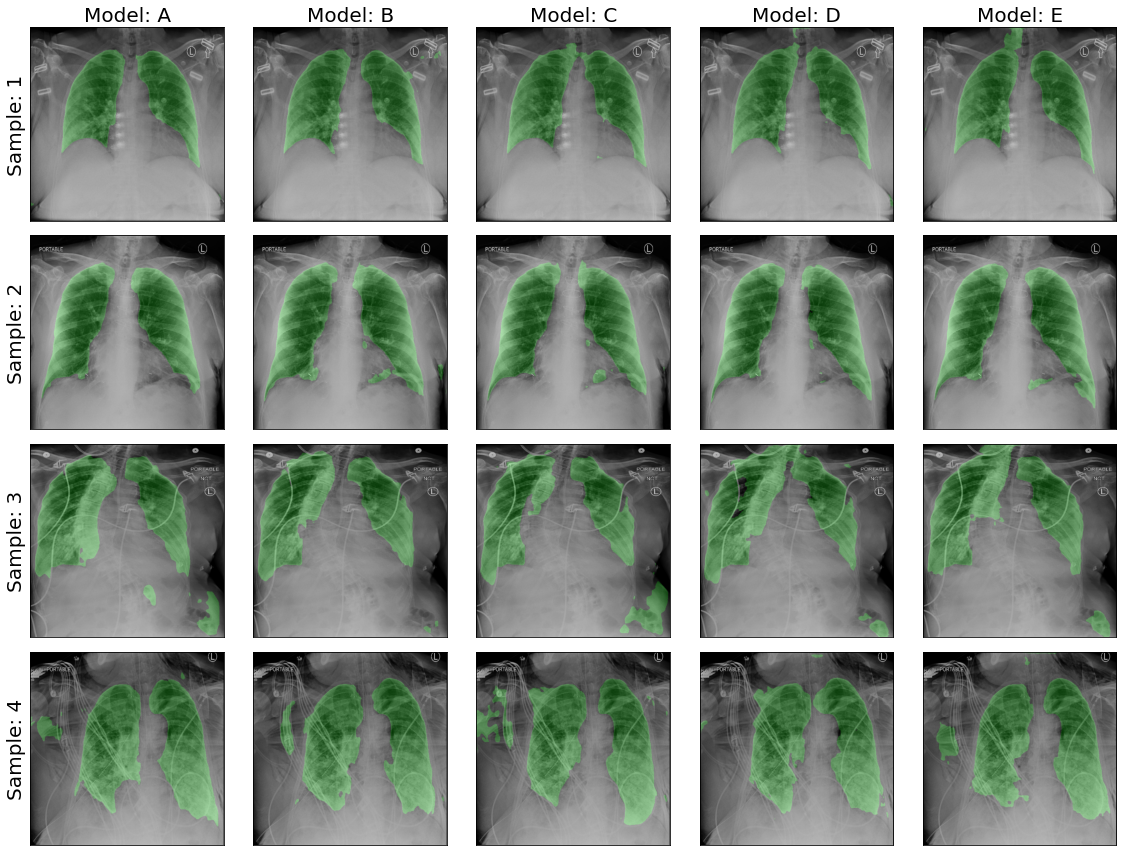

In [20]:
fig, ax = plt.subplots(len(sample), len(unets), figsize=(16,12), facecolor=(1., 1., 1.), sharex=True, sharey=True)
for j, m in enumerate(unets):
    for i, s in enumerate(sample):
        ax[i, j].imshow(infer_and_plot(s, m, plot=False, preproc=blur_adapthisteq))
        ax[i, j].set_xticks([]) 
        ax[i, j].set_yticks([])
        if j == 0: 
            ax[i,j].set_ylabel(f"Sample: {i+1}", fontsize=20)
        if i == 0:
            ax[i, j].set_title(f"Model: {mnames[j]}", fontsize=20)
fig.tight_layout()
fig.savefig("../thesis/figures/impl/model_comparison_blur_adapthist_clip0075.png")

In [21]:
from skimage.filters import median
from skimage.morphology import disk
from skimage.exposure import equalize_adapthist

def median_adapthisteq(img):
    _img = img.copy()
    _img = median(_img, disk(3))
    _img = equalize_adapthist(_img, clip_limit=0.0075)
    return _img

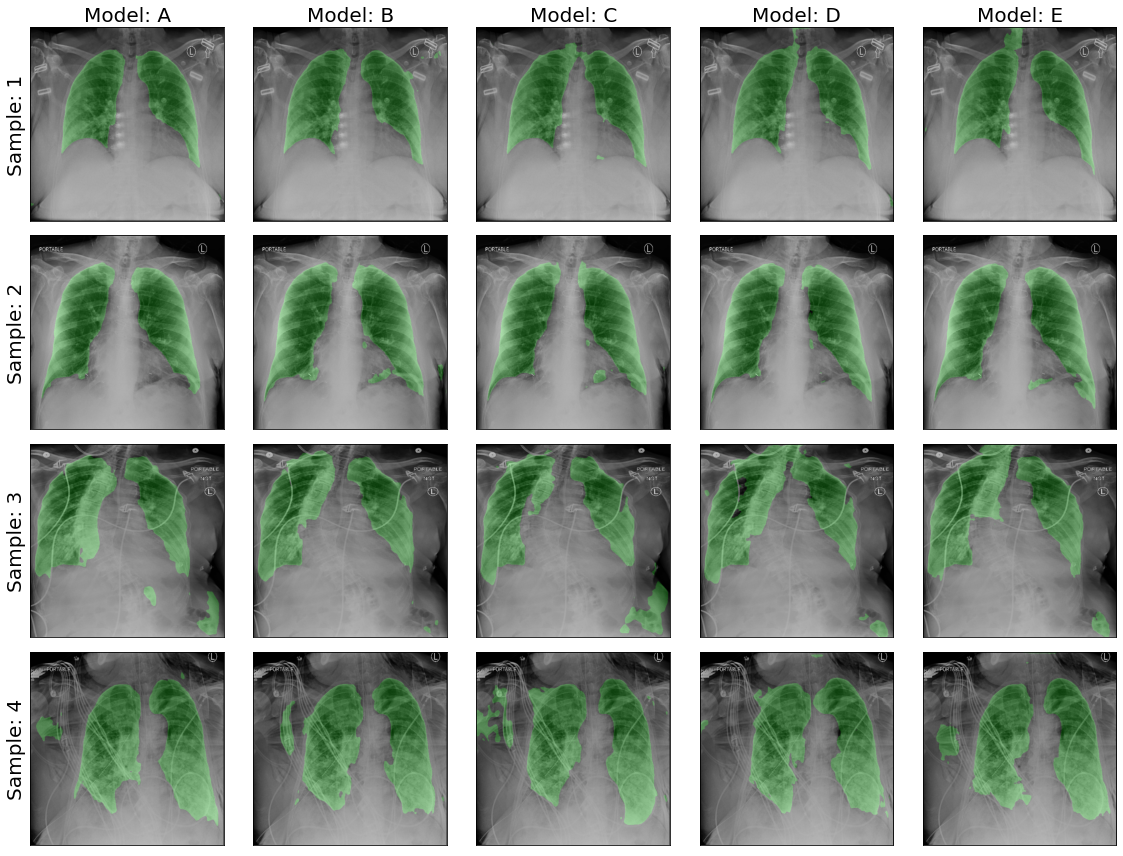

In [25]:
fig, ax = plt.subplots(len(sample), len(unets), figsize=(16,12), facecolor=(1., 1., 1.), sharex=True, sharey=True)
for j, m in enumerate(unets):
    for i, s in enumerate(sample):
        ax[i, j].imshow(infer_and_plot(s, m, plot=False, preproc=median_adapthisteq))
        ax[i, j].set_xticks([]) 
        ax[i, j].set_yticks([])
        if j == 0: 
            ax[i,j].set_ylabel(f"Sample: {i+1}", fontsize=20)
        if i == 0:
            ax[i, j].set_title(f"Model: {mnames[j]}", fontsize=20)
fig.tight_layout()
fig.savefig("../thesis/figures/impl/model_comparison_median_adapthist.png")

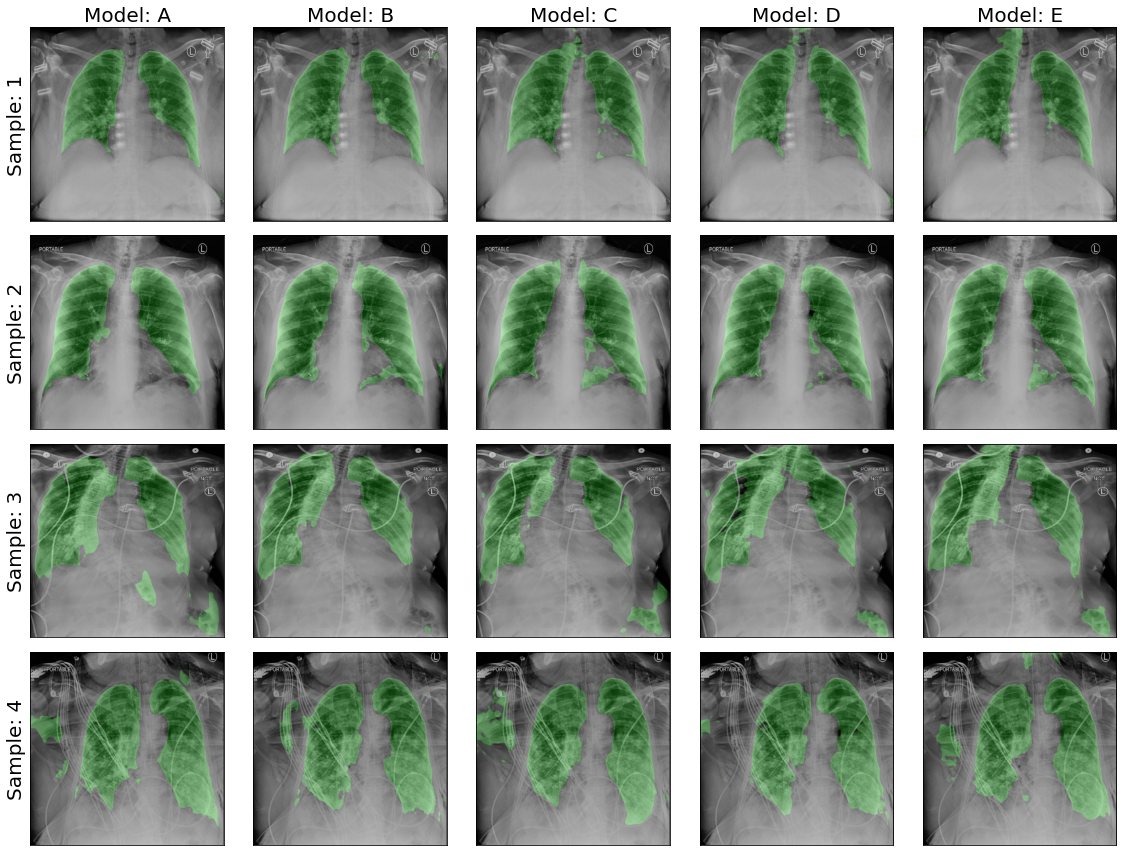

In [23]:
from skimage.filters import median
from skimage.morphology import disk
from skimage.exposure import equalize_adapthist

def blur_adapthisteq(img):
    _img = img.copy()
    _img = gaussian(_img, sigma=1)
    _img = equalize_adapthist(_img, clip_limit=0.01)
    return _img

fig, ax = plt.subplots(len(sample), len(unets), figsize=(16,12), facecolor=(1., 1., 1.), sharex=True, sharey=True)
for j, m in enumerate(unets):
    for i, s in enumerate(sample):
        ax[i, j].imshow(infer_and_plot(s, m, plot=False, preproc=blur_adapthisteq))
        ax[i, j].set_xticks([]) 
        ax[i, j].set_yticks([])
        if j == 0: 
            ax[i,j].set_ylabel(f"Sample: {i+1}", fontsize=20)
        if i == 0:
            ax[i, j].set_title(f"Model: {mnames[j]}", fontsize=20)
fig.tight_layout()
fig.savefig("../thesis/figures/impl/model_comparison_blur_adapthist_clip01.png")

---

0 255
tensor(0.) tensor(1.)
input array:  0 255
tensor:  tensor(-0.5000) tensor(0.5000)


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


input array:  0 255
tensor:  tensor(-0.5000) tensor(0.5000)
input array:  0 255
tensor:  tensor(-0.5000) tensor(0.5000)


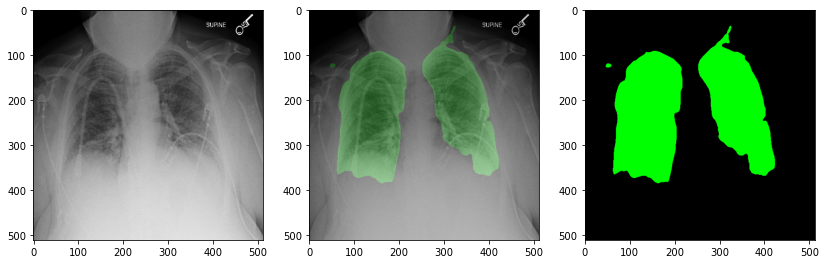

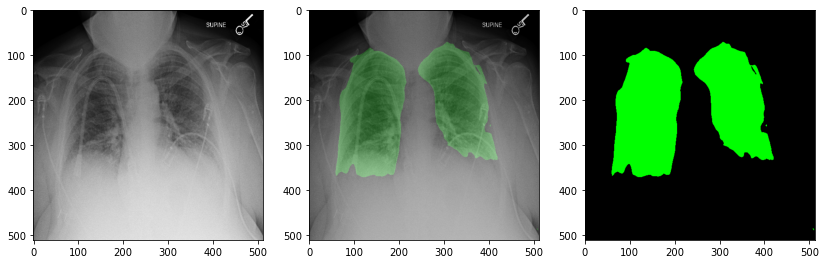

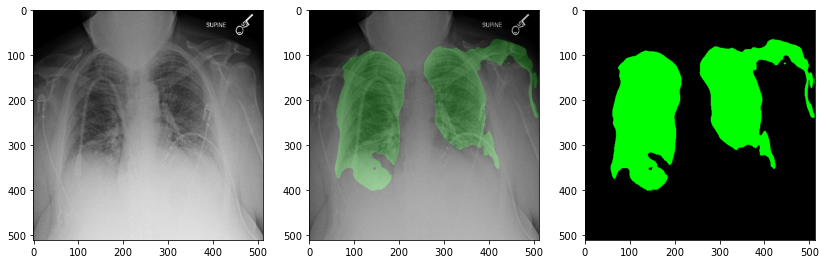

In [50]:
fpath = "/Volumes/Samsung_T5/MA/manifest-1638522923319/subsample/A027284/11-04-1900-NA-CHEST AP PORT-69465/1.000000-AP-91718/1-1.dcm"
#fpath="/Volumes/Samsung_T5/MA/manifest-1638522923319/segmented_sample/A000801/01-03-1901-NA-CHEST AP PORT-62879/1.000000-AP-12195/1-1.dcm"

dcm = dcmread(fpath)

origin = dcm.pixel_array
origin = np.round(origin/origin.max()*255) #scale between [0,1]
origin = Image.fromarray(origin).convert("P")
print(np.min(np.array(origin)), np.max(np.array(origin)))

foo = torchvision.transforms.functional.to_tensor(origin)
print(torch.min(foo), torch.max(foo))

for model in unets:
    infer_and_plot(origin, model)

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: UserWarning: Possible precision loss converting image of type int16 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/skimage/util/dtype.py:525: UserWarning: Downcasting int16 to uint8 without scaling because max value 255 fits in uint8
  return _convert(image, np.uint8, force_copy)


input array:  1 255
tensor:  tensor(-0.4961) tensor(0.5000)
input array:  1 255
tensor:  tensor(-0.4961) tensor(0.5000)
input array:  1 255
tensor:  tensor(-0.4961) tensor(0.5000)


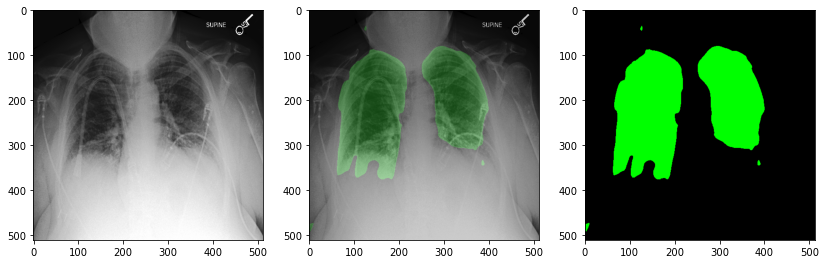

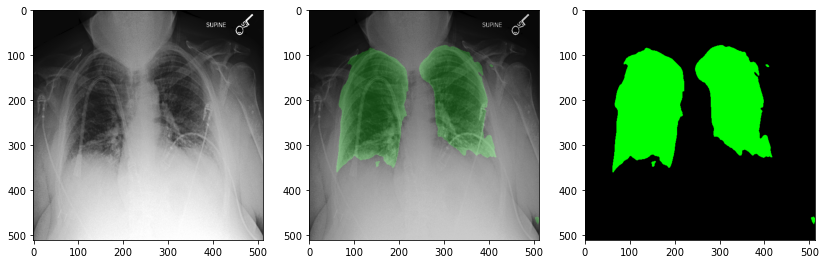

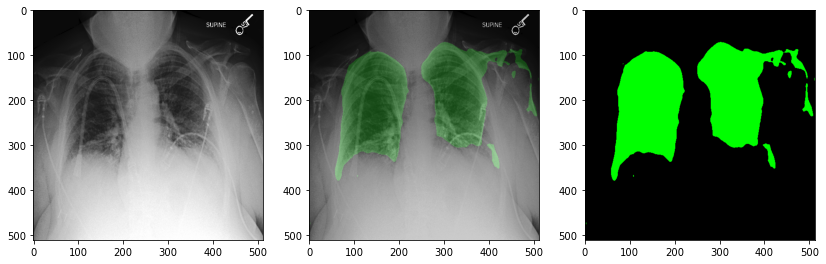

In [51]:
from skimage import exposure
from skimage.filters.rank import median

# Equalization
dcm = dcmread(fpath)

origin = dcm.pixel_array
origin = np.round(origin/origin.max() * 255) 
origin = origin.astype(np.int16)
#origin = Image.fromarray(origin).convert("P")


img_eq = median(origin)

img_eq = exposure.equalize_hist(img_eq)
#print(img_eq)
#print(np.round(img_eq*255))
#print(np.min(img_eq), np.max(img_eq))
img_eq = Image.fromarray(np.round(img_eq*255)).convert("P")

for model in unets:
    infer_and_plot(img_eq, model)


0 255
0.0 1.0
input array:  0 255
tensor:  tensor(-0.5000) tensor(0.5000)
input array:  0 255
tensor:  tensor(-0.5000) tensor(0.5000)
input array:  0 255
tensor:  tensor(-0.5000) tensor(0.5000)


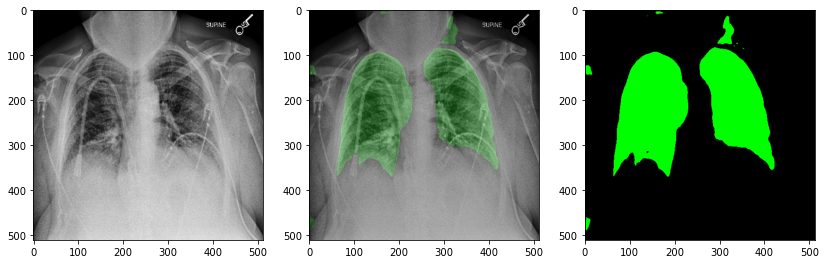

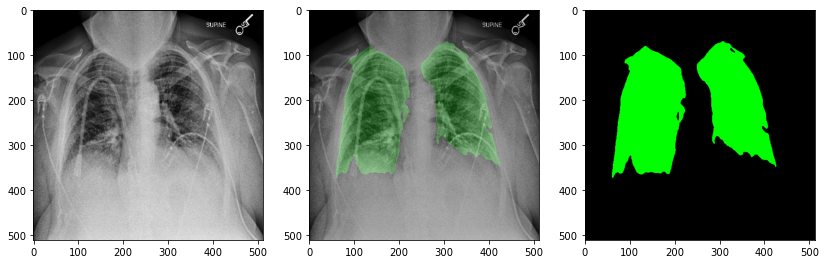

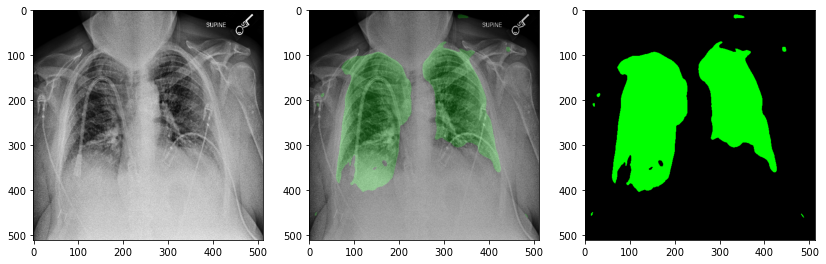

In [52]:
dcm = dcmread(fpath)

origin = dcm.pixel_array
origin = np.round(origin/origin.max() * 255) #scale between [0,255]
origin = origin.astype(np.int16)
#origin = Image.fromarray(origin).convert("P")

print(np.min(origin), np.max(origin))

# Equalization
img_eq = exposure.equalize_adapthist(origin)
print(np.min(img_eq), np.max(img_eq))

#img_eq = img_eq + 0.5
img_eq = Image.fromarray(np.round(img_eq*255)).convert("P")

for model in unets:
    infer_and_plot(img_eq, model)


0 248
0.0 1.0
input array:  0 255
tensor:  tensor(-0.5000) tensor(0.5000)
input array:  0 255
tensor:  tensor(-0.5000) tensor(0.5000)
input array:  0 255
tensor:  tensor(-0.5000) tensor(0.5000)


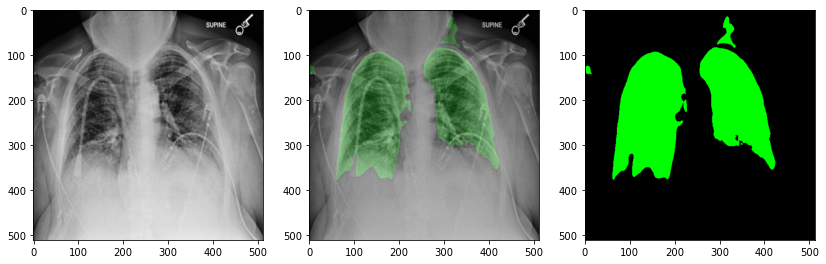

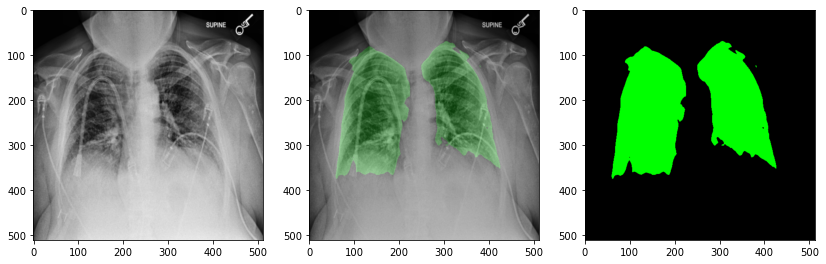

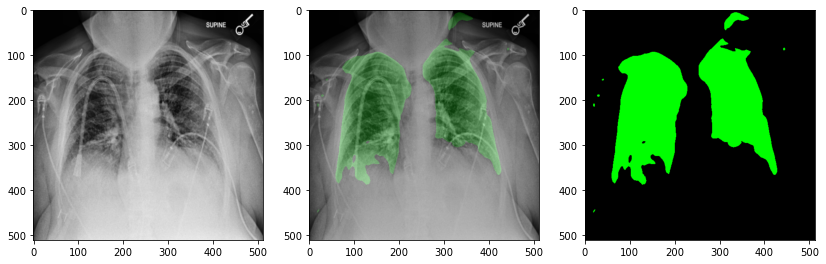

In [53]:
from skimage.filters import gaussian
dcm = dcmread(fpath)

origin = dcm.pixel_array
origin = origin/origin.max() #scale between [0,255]
#ax[0].imshow(origin, cmap="gray")
origin = np.round(gaussian(origin, sigma=3) * 255)
origin = origin.astype(np.int16)
#origin = Image.fromarray(origin).convert("P")
#ax[1].imshow(origin, cmap="gray")

print(np.min(origin), np.max(origin))
# Equalization
img_eq = exposure.equalize_adapthist(origin)
print(np.min(img_eq), np.max(img_eq))

#img_eq = img_eq + 0.5
img_eq = Image.fromarray(np.round(img_eq*255)).convert("P")

for model in unets:
    infer_and_plot(img_eq, model)

---
# Multiple

In [67]:
samples = ['/Volumes/Samsung_T5/MA/manifest-1638522923319/subsample/A401125/12-27-1900-NA-CHEST AP VIEWONLY-95577/1.000000-AP-85494/1-1.dcm',
 '/Volumes/Samsung_T5/MA/manifest-1638522923319/subsample/A416909/02-26-1901-NA-CHEST AP PORT-76147/1.000000-AP-16392/1-1.dcm',
 '/Volumes/Samsung_T5/MA/manifest-1638522923319/subsample/A751562/01-14-1901-NA-CHEST AP PORT-60468/1.000000-AP-29466/1-1.dcm',
 '/Volumes/Samsung_T5/MA/manifest-1638522923319/subsample/A099771/01-07-1901-NA-CHEST AP PORT-35147/1.000000-AP-14498/1-1.dcm',
 '/Volumes/Samsung_T5/MA/manifest-1638522923319/subsample/A117394/10-25-1900-NA-CHEST AP VIEWONLY-62779/1.000000-AP-58977/1-1.dcm',
 '/Volumes/Samsung_T5/MA/manifest-1638522923319/subsample/A117394/12-31-1900-NA-CHEST AP VIEWONLY-48017/1.000000-AP-38009/1-1.dcm',
 '/Volumes/Samsung_T5/MA/manifest-1638522923319/subsample/A700420/12-05-1900-NA-CHEST AP PORT-72865/1.000000-AP-81385/1-1.dcm',
 '/Volumes/Samsung_T5/MA/manifest-1638522923319/subsample/A117394/10-25-1900-NA-CHEST AP VIEWONLY-62779/1.000000-AP-58977/1-1.dcm',
 '/Volumes/Samsung_T5/MA/manifest-1638522923319/subsample/A670621/12-31-1900-NA-CHEST AP PORT-50540/1.000000-AP-55211/1-1.dcm',
 '/Volumes/Samsung_T5/MA/manifest-1638522923319/subsample/A751562/01-19-1901-NA-CHEST AP PORT-76813/1.000000-AP-28665/1-1.dcm',
 '/Volumes/Samsung_T5/MA/manifest-1638522923319/subsample/A978197/01-09-1901-NA-CHEST AP VIEWONLY-53035/1.000000-AP-42917/1-1.dcm',
 '/Volumes/Samsung_T5/MA/manifest-1638522923319/subsample/A751562/12-29-1900-NA-CHEST AP PORT-59604/1.000000-AP-62533/1-1.dcm']

tensor:  tensor(-0.5000) tensor(0.5000)


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.4961) tensor(0.4922)
tensor:  tensor(-0.4961) tensor(0.4922)
tensor:  tensor(-0.4961) tensor(0.4922)
tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)


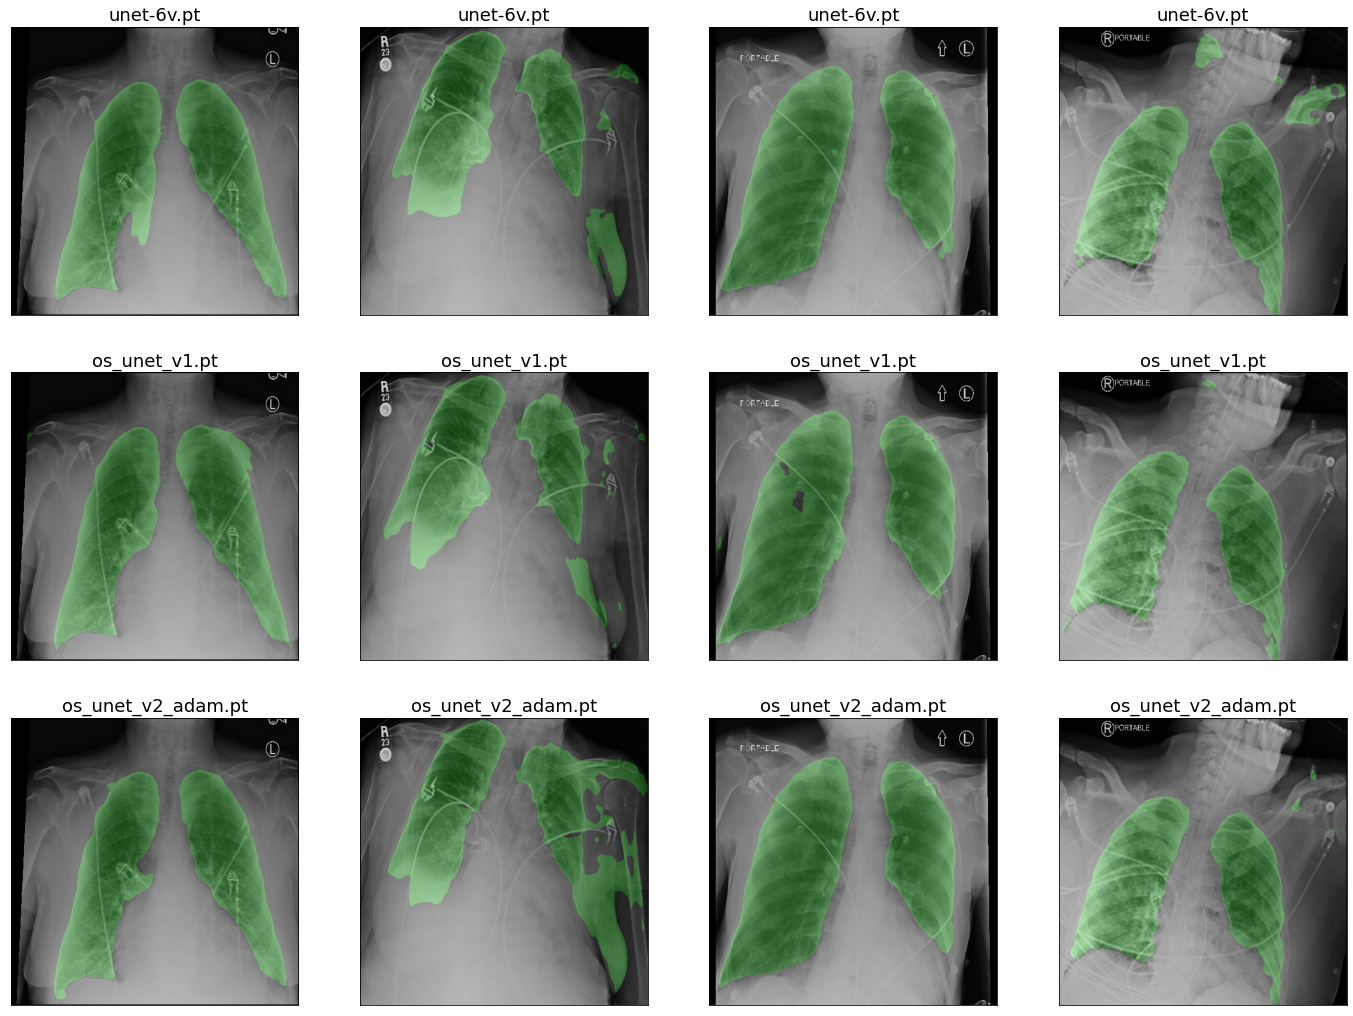

In [72]:
this_samples = samples[6:10]
fig, ax = plt.subplots(len(unets), len(this_samples), figsize=(24, 18))
for i, fpath in enumerate(this_samples):
    dcm = dcmread(fpath)

    origin = dcm.pixel_array
    origin = np.round(origin/origin.max()*255) #scale between [0,1]
    origin = Image.fromarray(origin).convert("P")
    
    for j, model in enumerate(unets):
        ax[j,i].imshow(infer_and_plot(origin, model, plot=False))
        ax[j,i].set_xticks([]) 
        ax[j,i].set_yticks([])
        ax[j,i].set_title(models[j], fontsize=18)

tensor:  tensor(-0.4961) tensor(0.5000)


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


tensor:  tensor(-0.4961) tensor(0.5000)
tensor:  tensor(-0.4961) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)


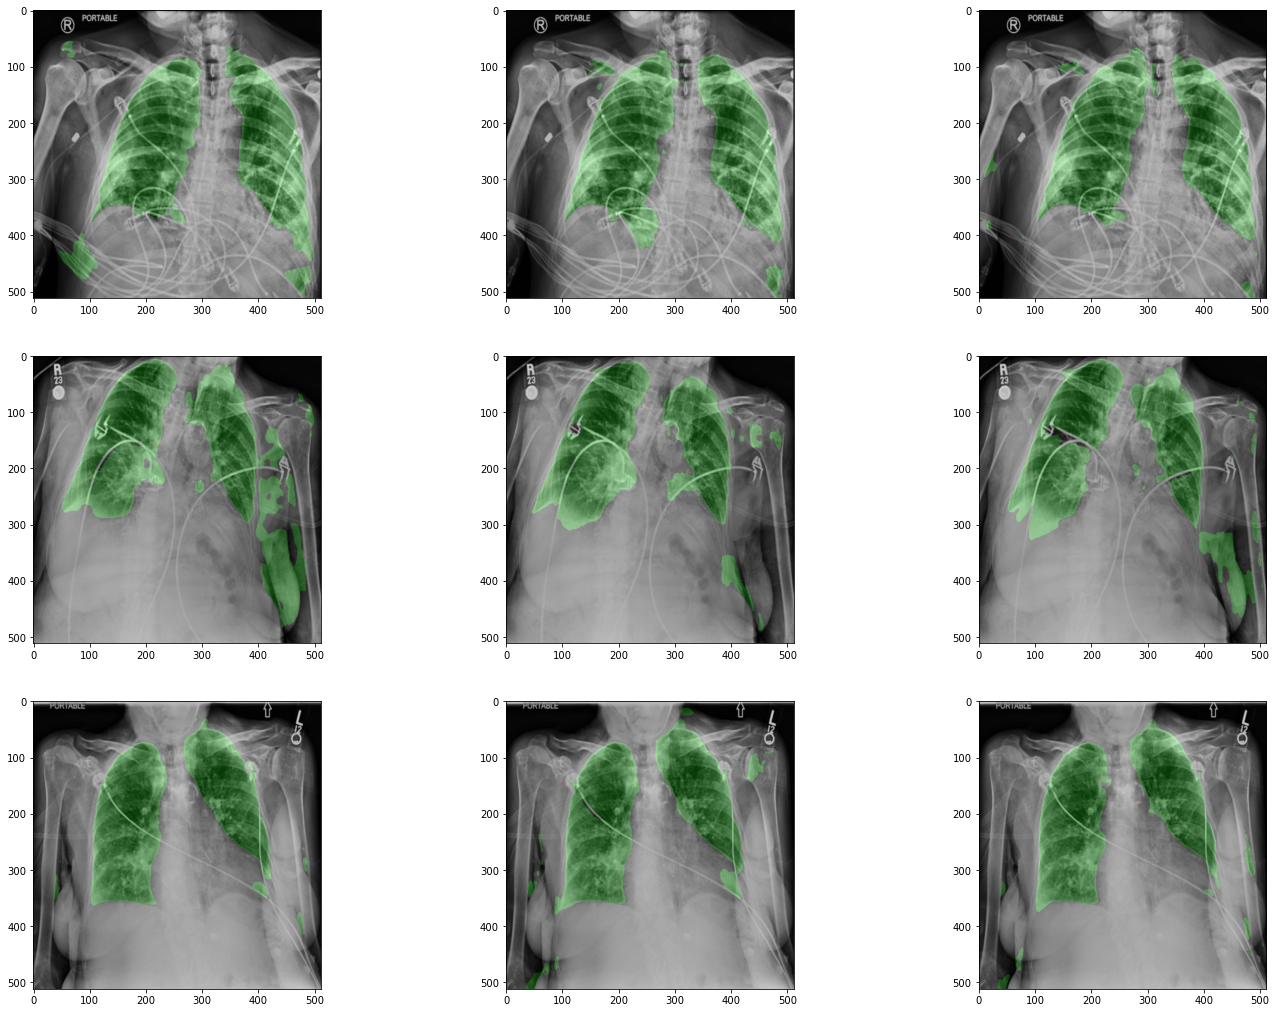

In [70]:
this_samples = samples[3:6]
fig, ax = plt.subplots(len(this_samples), len(unets), figsize=(24, 18))
for i, fpath in enumerate(this_samples):
    dcm = dcmread(fpath)

    origin = dcm.pixel_array
    origin = origin/origin.max() #scale between [0,255]
    #ax[0].imshow(origin, cmap="gray")
    origin = np.round(gaussian(origin, sigma=3) * 255)
    origin = origin.astype(np.int16)
    #origin = Image.fromarray(origin).convert("P")
    #ax[1].imshow(origin, cmap="gray")

    #print(np.min(origin), np.max(origin))
    # Equalization
    img_eq = exposure.equalize_adapthist(origin)
    #print(np.min(img_eq), np.max(img_eq))

    #img_eq = img_eq + 0.5
    img_eq = Image.fromarray(np.round(img_eq*255)).convert("P")

    for j, model in enumerate(unets):
        ax[i,j].imshow(infer_and_plot(img_eq, model, plot=False))